In [ ]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor               
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.io
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import math
from pyDOE import lhs
import time, sys
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cgpu')

print("The neural network will be trainied on",device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

viscosity=0.01/np.pi

The neural network will be trainied on cuda


In [234]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot,indexing='ij')
    u_xt = y
    fig = plt.figure()
    ax=fig.subplots(1,1)
    cp = ax.contourf(T,X,u_xt,20,cmap=cm.rainbow) #)levels = np.linspace(-1.0,1.0,12))
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(T.numpy(), X.numpy(), u_xt.numpy(),cmap=cm.rainbow, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    #ax.set_zlim3d(-1, 1)
    plt.show()

In [235]:
class u_NN(nn.Module):
    
    def __init__(self, layers_list):
        
        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean") #定义损失函数
    
        self.activation = nn.Tanh() #不能用Relu函数

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):
      
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #初始化权重，缩放因子为1.0
      
          nn.init.zeros_(self.linears[i].bias.data) #偏执设置为0.0

    def Convert(self, x): #辅助函数，将numpy数组转换为tensor
        
        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)
  
    def forward(self, x): #前向传播
        
        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)

        return a
    def loss_ic(self,x_ic,u_ic):
        l_ic = self.loss_function(self.forward(self.Convert(x_ic)), self.Convert(u_ic)) #L2 loss

        return l_ic
    def loss_bc(self,x_bc,u_bc):
        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss

        return l_bc

    def loss_inner(self, x_inner, u_inner):
        #内部点的损失函数
        l_inner = self.loss_function(self.forward(self.Convert(x_inner)), self.Convert(u_inner)) #L2 loss

        return l_inner
    
    def loss_pde(self, x_pde):
        #残差损失函数

        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT
    
        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNt = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNtt = torch.autograd.grad(NNx_NNt,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNtt[:,[0]] #Extract only dx2 terms

        NNt = NNx_NNt[:,[1]] #Extract only dt terms

        NNx = NNx_NNt[:,[0]] #Extract only dx terms
    
        # {(du/dt) = viscosity * (d2u/dx2)} is the pde and the NN residue will be {du_NN/dt - viscosity*(d2u_NN)/dx2} which is == {NNt - viscosity*NNxx}

        residue = NNt + self.forward(x_pde_clone)*(NNx) - (viscosity)*NNxx 

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue 

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde
    
    def total_loss(self,x_ic,u_ic,x_bc,u_bc, x_pde): #Combine both loss
        l_ic = self.loss_ic(x_ic,u_ic)
        l_bc = self.loss_bc(x_bc,u_bc)
        l_pde = self.loss_pde(x_pde)
        #l_inner = self.loss_inner(x_inner, u_inner)
        return l_ic+l_bc +  l_pde #+l_inner #this HAS to be a scalar value for auto differentiation to do its thing.

In [236]:
#边界点和内部点个数
if __name__ == '__main__':
    N_u = 100
    N_f = 10000
    
    
    #加载数据格式为t:100*1,x:256*1,usol:256*100
    data = scipy.io.loadmat('burgers_shock.mat')

    t = data['t'].flatten()[:, None] #将其转换为列向量
    x = data['x'].flatten()[:, None]
    Exact = np.real(data['usol']).T #100*256并提取实部

    # 生成 x 和 t 的网格点
    X, T = np.meshgrid(x, t)
    #生成两个形状为 (len(t), len(x)) 的二维数组 X 和 T。X 的每一行对应 x 的所有元素，T 的每一列对应 t 的所有元素

    # 将网格点展平并合并为一个二维数组，作为输入数据
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))#flatten转化为一维数组再升维为列向量
    #将 X 展开后的列向量和 T 展开后的列向量在列方向上拼接起来 (x_1,t_1;x_2,t_1;...) (100*256,2)
    
    u_star = Exact.flatten()[:, None] #将精确解其转换为列向量      

    # 边界
    lb = X_star.min(0) #取每一列的最小值 0是维度为行 1*2
    ub = X_star.max(0)

    # 提取 t = 0 ,x=-1,1边界的输入数据和精确解
    xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
    uu1 = Exact[0:1, :].T  #100个时间点的第一行 t=0的所有x点

    xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))     # X = -1 
    uu2 = Exact[:, 0:1]
    xx3 = np.hstack((X[:, -1:], T[:, -1:]))     # X = 1 
    uu3 = Exact[:, -1:]
    
    #xx_inner=np.hstack(X[])
    #uu_inner=Exact[1:, 1:-1]
xx1.shape,xx2.shape,xx3.shape,uu1.shape,uu2.shape,uu3.shape,Exact.shape#uu_inner.shape,xx_inner.shape


((256, 2), (100, 2), (100, 2), (256, 1), (100, 1), (100, 1), (100, 256))

In [237]:
#Sampling (X,T) domain using LHS
lhs_samples = lhs(2,N_f) 
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape
print(lhs_samples[1])


[0.81941485 0.44501308]


In [238]:
#边界条件
X_u_train_i=np.vstack([xx1,xx2])
u_train_i=np.vstack([uu1,uu2])
#初值条件
X_u_train_b=xx3
u_train_b=uu3

X_u_train_IBc=np.vstack([X_u_train_i,X_u_train_b])
u_train_IBc=np.vstack([u_train_i,u_train_b])

# 合并边界条件数据点
X_train_inner = lb + (ub-lb)*lhs_samples# 使用拉丁超立方抽样（LHS）生成内部数据点,二维数据点

X_f_train = np.vstack((X_train_inner, X_u_train_IBc)) # 将边界条件数据点添加到内部数据点中,或许不应该加边界

u_train = np.vstack([u_train_i, u_train_b]) # 合并所有边界条件的精确解
    
# 随机选择 N_u 个边界条件合并的数据点用于训练
idx = np.random.choice(X_u_train_IBc.shape[0], N_u, replace=False)
X_u_train = X_u_train_IBc[idx, :]
u_train = u_train[idx, :]
X_u_train.shape,u_train.shape,X_f_train.shape

((100, 2), (100, 1), (10456, 2))

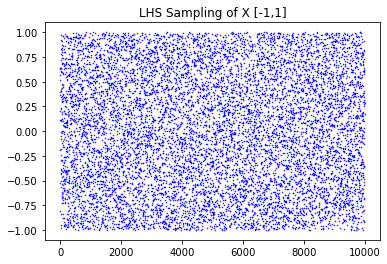

In [239]:
plt.plot(pd.DataFrame(X_train_inner)[0], "bo", markersize=.5)
plt.title("LHS Sampling of X [-1,1]")
plt.show()

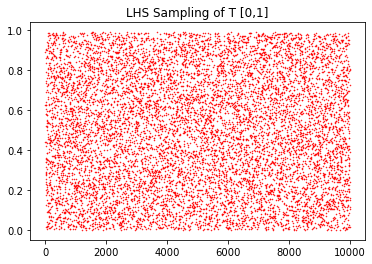

In [240]:
plt.plot(pd.DataFrame(X_train_inner)[1], "ro", markersize=.5)
plt.title("LHS Sampling of T [0,1]")
plt.show()

In [241]:
X_f_train.shape

(10456, 2)

In [242]:
EPOCHS = 100000
initial_lr = 0.001
layers_list = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#batch_size = 32

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])

u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [243]:
#****** Training ******#

print("Training Physics Informed Neural Network...")

Epoch = []
Learning_Rate = []
IC_Loss = []
BC_Loss = []
PDE_Loss = []
Total_Loss = []
Test_Loss = []

for i in tqdm(range(EPOCHS)):
    if i==0:
        print("Epoch \t Learning_Rate \t IC_Loss \t BC_Loss \t PDE_Loss \t Total_Loss \t Test_Loss")
    l_ic=PINN.loss_ic(X_u_train_i,u_train_i)    
    l_bc = PINN.loss_bc(X_u_train_b,u_train_b)
    #l_inner = PINN.loss_inner(X_)
    l_pde = PINN.loss_pde(X_f_train)

    loss = PINN.total_loss(X_u_train_i,u_train_i,X_u_train_b,u_train_b,X_f_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%100 == 0: #print losses and step the exponential learning rate.
                
        with torch.no_grad():
            test_loss = PINN.loss_bc(X_star,u_star) 
            #Here we are using loss_bc method as a helper function to calculate L2 loss
            
            Epoch.append(i)
            Learning_Rate.append(scheduler.get_last_lr()[0])
            IC_Loss.append(l_ic.detach().cpu().numpy())
            BC_Loss.append(l_bc.detach().cpu().numpy())
            PDE_Loss.append(l_pde.detach().cpu().numpy())
            Total_Loss.append(loss.detach().cpu().numpy())
            Test_Loss.append(test_loss.detach().cpu().numpy())

            if i%1000 ==0:
               print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_ic.detach().cpu().numpy(),".4E"),'\t',format(l_bc.detach().cpu().numpy(),".4E"),'\t',
                  format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))
 
        scheduler.step()

print("Completed!!")

Training Physics Informed Neural Network...


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 	 Learning_Rate 	 IC_Loss 	 BC_Loss 	 PDE_Loss 	 Total_Loss 	 Test_Loss
0 	 1.0000E-03 	 2.6880E-01 	 3.0081E-02 	 7.6378E-02 	 3.7526E-01 	 

  0%|          | 1/100000 [00:00<4:40:00,  5.95it/s]

3.2151E-01


  1%|          | 1003/100000 [00:51<1:33:20, 17.68it/s]

1000 	 8.5973E-04 	 2.0743E-02 	 1.7264E-04 	 1.6541E-02 	 3.7457E-02 	 3.7854E-02


  2%|▏         | 2003/100000 [01:39<1:15:44, 21.57it/s]

2000 	 7.3914E-04 	 2.6900E-03 	 1.4112E-04 	 4.7708E-03 	 7.6019E-03 	 5.7130E-03


  3%|▎         | 3005/100000 [02:20<1:07:57, 23.79it/s]

3000 	 6.3546E-04 	 1.1642E-03 	 2.2085E-05 	 1.6997E-03 	 2.8861E-03 	 4.1074E-03


  4%|▍         | 4004/100000 [03:04<1:17:51, 20.55it/s]

4000 	 5.4632E-04 	 6.2264E-04 	 4.5176E-06 	 1.1125E-03 	 1.7397E-03 	 3.0552E-03


  5%|▌         | 5004/100000 [03:51<1:17:00, 20.56it/s]

5000 	 4.6969E-04 	 3.5726E-04 	 4.9667E-06 	 6.8149E-04 	 1.0437E-03 	 2.2248E-03


  6%|▌         | 6005/100000 [04:38<1:15:28, 20.76it/s]

6000 	 4.0381E-04 	 2.2987E-04 	 3.0288E-05 	 9.2922E-04 	 1.1894E-03 	 1.7170E-03


  7%|▋         | 7004/100000 [05:22<1:07:13, 23.05it/s]

7000 	 3.4717E-04 	 1.7153E-04 	 6.6658E-07 	 4.1748E-04 	 5.8968E-04 	 9.9528E-04


  8%|▊         | 8004/100000 [06:03<1:08:23, 22.42it/s]

8000 	 2.9847E-04 	 1.3622E-04 	 1.4461E-06 	 3.9190E-04 	 5.2957E-04 	 9.8254E-04


  9%|▉         | 9004/100000 [06:48<1:22:31, 18.38it/s]

9000 	 2.5660E-04 	 1.0764E-04 	 8.9967E-06 	 3.1478E-04 	 4.3142E-04 	 8.8717E-04


 10%|█         | 10004/100000 [07:34<1:10:41, 21.22it/s]

10000 	 2.2061E-04 	 9.0398E-05 	 1.2632E-06 	 2.8182E-04 	 3.7348E-04 	 8.0713E-04


 11%|█         | 11005/100000 [08:19<1:08:25, 21.68it/s]

11000 	 1.8966E-04 	 8.0338E-05 	 1.4688E-06 	 2.6935E-04 	 3.5116E-04 	 8.3306E-04


 12%|█▏        | 12004/100000 [09:01<58:27, 25.09it/s]  

12000 	 1.6306E-04 	 7.0661E-05 	 1.0579E-06 	 2.3280E-04 	 3.0452E-04 	 8.0548E-04


 13%|█▎        | 13003/100000 [09:42<1:07:33, 21.46it/s]

13000 	 1.4019E-04 	 6.3741E-05 	 1.3742E-06 	 2.0678E-04 	 2.7189E-04 	 7.8985E-04


 14%|█▍        | 14003/100000 [10:28<1:05:41, 21.82it/s]

14000 	 1.2052E-04 	 6.4663E-05 	 1.2653E-06 	 2.6871E-04 	 3.3464E-04 	 1.3242E-03


 15%|█▌        | 15005/100000 [11:12<1:04:26, 21.98it/s]

15000 	 1.0362E-04 	 5.2956E-05 	 1.3865E-06 	 1.7672E-04 	 2.3106E-04 	 7.1695E-04


 16%|█▌        | 16004/100000 [11:57<1:02:04, 22.55it/s]

16000 	 8.9083E-05 	 4.9470E-05 	 1.1361E-06 	 1.7477E-04 	 2.2538E-04 	 7.4307E-04


 17%|█▋        | 17006/100000 [12:38<56:16, 24.58it/s]  

17000 	 7.6588E-05 	 4.8566E-05 	 1.4094E-06 	 1.8840E-04 	 2.3837E-04 	 7.1985E-04


 18%|█▊        | 18005/100000 [13:19<1:03:09, 21.64it/s]

18000 	 6.5845E-05 	 4.5079E-05 	 1.4245E-06 	 2.0344E-04 	 2.4994E-04 	 6.4008E-04


 19%|█▉        | 19004/100000 [14:04<1:02:11, 21.70it/s]

19000 	 5.6609E-05 	 4.3607E-05 	 8.0978E-07 	 1.5623E-04 	 2.0064E-04 	 6.4053E-04


 20%|██        | 20003/100000 [14:49<1:02:30, 21.33it/s]

20000 	 4.8668E-05 	 4.0599E-05 	 7.4246E-07 	 1.3855E-04 	 1.7989E-04 	 6.2212E-04


 21%|██        | 21005/100000 [15:33<58:57, 22.33it/s]  

21000 	 4.1842E-05 	 3.9265E-05 	 6.8358E-07 	 1.3673E-04 	 1.7668E-04 	 6.0473E-04


 22%|██▏       | 22004/100000 [16:12<51:07, 25.42it/s]

22000 	 3.5973E-05 	 3.7830E-05 	 1.7691E-06 	 1.3503E-04 	 1.7463E-04 	 6.7363E-04


 23%|██▎       | 23003/100000 [16:55<57:49, 22.19it/s]  

23000 	 3.0927E-05 	 3.6981E-05 	 6.6789E-07 	 1.2955E-04 	 1.6720E-04 	 5.7979E-04


 24%|██▍       | 24002/100000 [17:40<57:28, 22.04it/s]  

24000 	 2.6589E-05 	 3.7036E-05 	 6.6487E-07 	 1.2214E-04 	 1.5984E-04 	 5.5750E-04


 25%|██▌       | 25004/100000 [18:24<56:35, 22.09it/s]  

25000 	 2.2859E-05 	 3.5168E-05 	 1.9852E-06 	 1.4200E-04 	 1.7915E-04 	 5.8719E-04


 26%|██▌       | 26004/100000 [19:07<51:14, 24.06it/s]  

26000 	 1.9653E-05 	 3.4744E-05 	 8.3385E-07 	 1.1770E-04 	 1.5328E-04 	 5.8438E-04


 27%|██▋       | 27003/100000 [19:47<50:18, 24.19it/s]

27000 	 1.6896E-05 	 3.3622E-05 	 7.7255E-07 	 1.1969E-04 	 1.5409E-04 	 5.3866E-04


 28%|██▊       | 28004/100000 [20:31<56:53, 21.09it/s]  

28000 	 1.4526E-05 	 3.3879E-05 	 5.8754E-07 	 1.0655E-04 	 1.4102E-04 	 5.6589E-04


 29%|██▉       | 29004/100000 [21:16<53:15, 22.22it/s]  

29000 	 1.2488E-05 	 3.2381E-05 	 7.7475E-07 	 1.1450E-04 	 1.4766E-04 	 5.5680E-04


 30%|███       | 30004/100000 [22:00<55:15, 21.11it/s]  

30000 	 1.0737E-05 	 3.1982E-05 	 6.4097E-07 	 1.0886E-04 	 1.4149E-04 	 4.9494E-04


 31%|███       | 31004/100000 [22:44<44:29, 25.85it/s]  

31000 	 9.2306E-06 	 3.1741E-05 	 7.7221E-07 	 1.0441E-04 	 1.3692E-04 	 5.2331E-04


 32%|███▏      | 32006/100000 [23:23<47:14, 23.99it/s]

32000 	 7.9359E-06 	 3.1394E-05 	 5.4858E-07 	 1.0395E-04 	 1.3589E-04 	 5.4517E-04


 33%|███▎      | 33005/100000 [24:07<53:34, 20.84it/s]

33000 	 6.8227E-06 	 3.0996E-05 	 8.8437E-07 	 1.0196E-04 	 1.3384E-04 	 5.5667E-04


 34%|███▍      | 34003/100000 [24:52<58:24, 18.83it/s]

34000 	 5.8657E-06 	 3.0574E-05 	 7.4190E-07 	 1.0789E-04 	 1.3920E-04 	 5.4661E-04


 35%|███▌      | 35003/100000 [25:37<50:37, 21.40it/s]

35000 	 5.0429E-06 	 3.0840E-05 	 6.5557E-07 	 1.0207E-04 	 1.3357E-04 	 5.6728E-04


 36%|███▌      | 36005/100000 [26:19<42:50, 24.90it/s]

36000 	 4.3355E-06 	 2.9983E-05 	 5.5584E-07 	 9.9242E-05 	 1.2978E-04 	 5.1783E-04


 37%|███▋      | 37004/100000 [27:01<46:37, 22.51it/s]

37000 	 3.7274E-06 	 2.9646E-05 	 1.1448E-06 	 1.0059E-04 	 1.3138E-04 	 4.9449E-04


 38%|███▊      | 38003/100000 [27:45<45:25, 22.74it/s]

38000 	 3.2046E-06 	 3.0454E-05 	 5.9744E-07 	 1.0344E-04 	 1.3449E-04 	 5.1578E-04


 39%|███▉      | 39005/100000 [28:30<46:03, 22.07it/s]

39000 	 2.7551E-06 	 2.9818E-05 	 8.8060E-07 	 9.8273E-05 	 1.2897E-04 	 4.9580E-04


 40%|████      | 40004/100000 [29:15<45:07, 22.16it/s]

40000 	 2.3686E-06 	 3.0171E-05 	 5.8498E-07 	 9.8624E-05 	 1.2938E-04 	 4.8581E-04


 41%|████      | 41006/100000 [29:56<36:51, 26.67it/s]

41000 	 2.0364E-06 	 2.9616E-05 	 6.3996E-07 	 9.8477E-05 	 1.2873E-04 	 4.9024E-04


 42%|████▏     | 42005/100000 [30:37<45:18, 21.33it/s]

42000 	 1.7507E-06 	 2.9291E-05 	 7.9582E-07 	 1.0004E-04 	 1.3013E-04 	 5.2161E-04


 43%|████▎     | 43003/100000 [31:22<42:20, 22.44it/s]

43000 	 1.5051E-06 	 2.9698E-05 	 8.6186E-07 	 9.8548E-05 	 1.2911E-04 	 5.1411E-04


 44%|████▍     | 44005/100000 [32:07<43:10, 21.62it/s]

44000 	 1.2940E-06 	 2.9472E-05 	 7.8549E-07 	 1.0202E-04 	 1.3228E-04 	 5.0597E-04


 45%|████▌     | 45003/100000 [32:51<38:55, 23.55it/s]

45000 	 1.1125E-06 	 2.9777E-05 	 6.4171E-07 	 9.7265E-05 	 1.2768E-04 	 5.0711E-04


 46%|████▌     | 46005/100000 [33:31<37:24, 24.06it/s]

46000 	 9.5646E-07 	 2.8875E-05 	 8.1799E-07 	 1.1058E-04 	 1.4027E-04 	 4.9644E-04


 47%|████▋     | 47004/100000 [34:15<41:43, 21.17it/s]

47000 	 8.2230E-07 	 2.9127E-05 	 9.5690E-07 	 1.0344E-04 	 1.3352E-04 	 4.9912E-04


 48%|████▊     | 48003/100000 [34:59<37:55, 22.85it/s]

48000 	 7.0695E-07 	 2.9926E-05 	 7.6009E-07 	 1.0808E-04 	 1.3876E-04 	 5.0294E-04


 49%|████▉     | 49005/100000 [35:44<38:23, 22.13it/s]

49000 	 6.0779E-07 	 3.0142E-05 	 5.6082E-07 	 1.0106E-04 	 1.3176E-04 	 5.1198E-04


 50%|█████     | 50004/100000 [36:28<34:13, 24.35it/s]

50000 	 5.2253E-07 	 2.9488E-05 	 6.6989E-07 	 9.9937E-05 	 1.3009E-04 	 5.1791E-04


 51%|█████     | 51006/100000 [37:08<31:37, 25.82it/s]

51000 	 4.4924E-07 	 2.9441E-05 	 6.3753E-07 	 9.4710E-05 	 1.2479E-04 	 5.2002E-04


 52%|█████▏    | 52003/100000 [37:51<38:07, 20.98it/s]

52000 	 3.8622E-07 	 2.8998E-05 	 7.5477E-07 	 9.8718E-05 	 1.2847E-04 	 5.2408E-04


 53%|█████▎    | 53005/100000 [38:36<36:19, 21.56it/s]

53000 	 3.3205E-07 	 2.9021E-05 	 6.0525E-07 	 1.0041E-04 	 1.3004E-04 	 5.1430E-04


 54%|█████▍    | 54004/100000 [39:21<36:07, 21.22it/s]

54000 	 2.8547E-07 	 2.9002E-05 	 7.5587E-07 	 9.7500E-05 	 1.2726E-04 	 4.9816E-04


 55%|█████▌    | 55004/100000 [40:05<33:11, 22.60it/s]

55000 	 2.4543E-07 	 2.8991E-05 	 7.6224E-07 	 1.0035E-04 	 1.3010E-04 	 5.1660E-04


 56%|█████▌    | 56003/100000 [40:44<33:14, 22.06it/s]

56000 	 2.1100E-07 	 2.9296E-05 	 8.2849E-07 	 9.8135E-05 	 1.2826E-04 	 5.1664E-04


 57%|█████▋    | 57005/100000 [41:28<34:27, 20.79it/s]

57000 	 1.8141E-07 	 2.9306E-05 	 5.8318E-07 	 9.8571E-05 	 1.2846E-04 	 5.0960E-04


 58%|█████▊    | 58004/100000 [42:13<31:22, 22.31it/s]

58000 	 1.5596E-07 	 2.9061E-05 	 6.4994E-07 	 1.0587E-04 	 1.3558E-04 	 5.0181E-04


 59%|█████▉    | 59003/100000 [42:57<30:46, 22.20it/s]

59000 	 1.3408E-07 	 2.9198E-05 	 7.2961E-07 	 1.0093E-04 	 1.3086E-04 	 5.1451E-04


 60%|██████    | 60005/100000 [43:41<27:46, 24.00it/s]

60000 	 1.1528E-07 	 2.9031E-05 	 6.9857E-07 	 1.0329E-04 	 1.3302E-04 	 5.0116E-04


 61%|██████    | 61004/100000 [44:20<27:26, 23.68it/s]

61000 	 9.9106E-08 	 2.9007E-05 	 7.0897E-07 	 9.9069E-05 	 1.2878E-04 	 5.0142E-04


 62%|██████▏   | 62003/100000 [45:04<29:19, 21.60it/s]

62000 	 8.5205E-08 	 2.9012E-05 	 8.4214E-07 	 1.0353E-04 	 1.3339E-04 	 4.9964E-04


 63%|██████▎   | 63005/100000 [45:49<27:41, 22.27it/s]

63000 	 7.3253E-08 	 2.9259E-05 	 6.0485E-07 	 1.0168E-04 	 1.3154E-04 	 4.9651E-04


 64%|██████▍   | 64004/100000 [46:33<28:30, 21.05it/s]

64000 	 6.2978E-08 	 2.9100E-05 	 5.8092E-07 	 9.9688E-05 	 1.2937E-04 	 4.9164E-04


 65%|██████▌   | 65003/100000 [47:15<22:29, 25.94it/s]

65000 	 5.4144E-08 	 2.9117E-05 	 5.1757E-07 	 1.0091E-04 	 1.3054E-04 	 4.9248E-04


 66%|██████▌   | 66005/100000 [47:54<22:49, 24.82it/s]

66000 	 4.6549E-08 	 2.8982E-05 	 5.9875E-07 	 9.9896E-05 	 1.2948E-04 	 4.8575E-04


 67%|██████▋   | 67004/100000 [48:39<25:28, 21.59it/s]

67000 	 4.0020E-08 	 2.9008E-05 	 6.3791E-07 	 9.9567E-05 	 1.2921E-04 	 4.9023E-04


 68%|██████▊   | 68003/100000 [49:24<25:46, 20.69it/s]

68000 	 3.4406E-08 	 2.8932E-05 	 5.9176E-07 	 9.9400E-05 	 1.2892E-04 	 4.9086E-04


 69%|██████▉   | 69003/100000 [50:09<23:08, 22.32it/s]

69000 	 2.9580E-08 	 2.9010E-05 	 5.9847E-07 	 1.0007E-04 	 1.2968E-04 	 4.9219E-04


 70%|███████   | 70005/100000 [50:51<19:21, 25.82it/s]

70000 	 2.5431E-08 	 2.8976E-05 	 6.2444E-07 	 9.8881E-05 	 1.2848E-04 	 4.9542E-04


 71%|███████   | 71004/100000 [51:32<21:43, 22.25it/s]

71000 	 2.1864E-08 	 2.8895E-05 	 6.3818E-07 	 9.5262E-05 	 1.2479E-04 	 4.9630E-04


 72%|███████▏  | 72003/100000 [52:16<21:06, 22.11it/s]

72000 	 1.8797E-08 	 2.9019E-05 	 6.0444E-07 	 1.0121E-04 	 1.3084E-04 	 5.0140E-04


 73%|███████▎  | 73005/100000 [53:01<20:13, 22.25it/s]

73000 	 1.6160E-08 	 2.9100E-05 	 6.7591E-07 	 9.6159E-05 	 1.2594E-04 	 4.9204E-04


 74%|███████▍  | 74004/100000 [53:46<19:13, 22.54it/s]

74000 	 1.3893E-08 	 2.8991E-05 	 6.7520E-07 	 9.2681E-05 	 1.2235E-04 	 4.9116E-04


 75%|███████▌  | 75003/100000 [54:27<16:03, 25.95it/s]

75000 	 1.1945E-08 	 2.9099E-05 	 6.4264E-07 	 9.5810E-05 	 1.2555E-04 	 4.9215E-04


 76%|███████▌  | 76002/100000 [55:09<18:44, 21.34it/s]

76000 	 1.0269E-08 	 2.9083E-05 	 6.4667E-07 	 9.7315E-05 	 1.2704E-04 	 4.9635E-04


 77%|███████▋  | 77004/100000 [55:54<17:10, 22.32it/s]

77000 	 8.8287E-09 	 2.9121E-05 	 6.7862E-07 	 9.7788E-05 	 1.2759E-04 	 4.9407E-04


 78%|███████▊  | 78003/100000 [56:39<16:48, 21.80it/s]

78000 	 7.5903E-09 	 2.9134E-05 	 6.9988E-07 	 1.0321E-04 	 1.3305E-04 	 4.9528E-04


 79%|███████▉  | 79005/100000 [57:23<15:09, 23.08it/s]

79000 	 6.5256E-09 	 2.9235E-05 	 6.4496E-07 	 9.3542E-05 	 1.2342E-04 	 4.9419E-04


 80%|████████  | 80004/100000 [58:03<12:47, 26.05it/s]

80000 	 5.6103E-09 	 2.9081E-05 	 6.8289E-07 	 9.5166E-05 	 1.2493E-04 	 4.9734E-04


 81%|████████  | 81003/100000 [58:46<14:14, 22.23it/s]

81000 	 4.8233E-09 	 2.9051E-05 	 6.6128E-07 	 9.6391E-05 	 1.2610E-04 	 4.9509E-04


 82%|████████▏ | 82004/100000 [59:31<13:43, 21.84it/s]

82000 	 4.1468E-09 	 2.9001E-05 	 6.3763E-07 	 9.4098E-05 	 1.2374E-04 	 4.9205E-04


 83%|████████▎ | 83005/100000 [1:00:16<12:52, 22.00it/s]

83000 	 3.5651E-09 	 2.8937E-05 	 6.9696E-07 	 9.7009E-05 	 1.2664E-04 	 4.9576E-04


 84%|████████▍ | 84004/100000 [1:01:00<10:52, 24.52it/s]

84000 	 3.0650E-09 	 2.8939E-05 	 6.5062E-07 	 9.7372E-05 	 1.2696E-04 	 4.9833E-04


 85%|████████▌ | 85003/100000 [1:01:40<10:00, 24.98it/s]

85000 	 2.6351E-09 	 2.8963E-05 	 6.4739E-07 	 9.6613E-05 	 1.2622E-04 	 5.0125E-04


 86%|████████▌ | 86004/100000 [1:02:24<10:44, 21.72it/s]

86000 	 2.2655E-09 	 2.9076E-05 	 5.7167E-07 	 9.8344E-05 	 1.2799E-04 	 5.0347E-04


 87%|████████▋ | 87003/100000 [1:03:09<09:52, 21.93it/s]

87000 	 1.9477E-09 	 2.9052E-05 	 6.5137E-07 	 9.5813E-05 	 1.2552E-04 	 5.0352E-04


 88%|████████▊ | 88005/100000 [1:03:53<09:00, 22.19it/s]

88000 	 1.6745E-09 	 2.9047E-05 	 6.3462E-07 	 9.4853E-05 	 1.2453E-04 	 5.0379E-04


 89%|████████▉ | 89004/100000 [1:04:36<08:08, 22.51it/s]

89000 	 1.4396E-09 	 2.9057E-05 	 6.1551E-07 	 9.4700E-05 	 1.2437E-04 	 5.0534E-04


 90%|█████████ | 90003/100000 [1:05:15<07:37, 21.85it/s]

90000 	 1.2377E-09 	 2.9062E-05 	 5.7615E-07 	 9.6093E-05 	 1.2573E-04 	 5.0567E-04


 91%|█████████ | 91005/100000 [1:06:00<06:53, 21.74it/s]

91000 	 1.0641E-09 	 2.9084E-05 	 5.7364E-07 	 9.6352E-05 	 1.2601E-04 	 5.0544E-04


 92%|█████████▏| 92003/100000 [1:06:44<05:52, 22.67it/s]

92000 	 9.1481E-10 	 2.9072E-05 	 5.8918E-07 	 9.8158E-05 	 1.2782E-04 	 5.0508E-04


 93%|█████████▎| 93005/100000 [1:07:29<05:50, 19.94it/s]

93000 	 7.8649E-10 	 2.9061E-05 	 6.0208E-07 	 9.7409E-05 	 1.2707E-04 	 5.0523E-04


 94%|█████████▍| 94004/100000 [1:08:12<04:05, 24.43it/s]

94000 	 6.7617E-10 	 2.9069E-05 	 6.0279E-07 	 9.7384E-05 	 1.2706E-04 	 5.0582E-04


 95%|█████████▌| 95003/100000 [1:08:51<03:22, 24.72it/s]

95000 	 5.8132E-10 	 2.9092E-05 	 5.9774E-07 	 9.7051E-05 	 1.2674E-04 	 5.0576E-04


 96%|█████████▌| 96002/100000 [1:09:35<03:03, 21.76it/s]

96000 	 4.9978E-10 	 2.9107E-05 	 6.2037E-07 	 9.8094E-05 	 1.2782E-04 	 5.0593E-04


 97%|█████████▋| 97003/100000 [1:10:20<02:15, 22.08it/s]

97000 	 4.2968E-10 	 2.9112E-05 	 5.9011E-07 	 9.8083E-05 	 1.2779E-04 	 5.0597E-04


 98%|█████████▊| 98004/100000 [1:11:05<01:30, 22.09it/s]

98000 	 3.6941E-10 	 2.9103E-05 	 5.9592E-07 	 9.7715E-05 	 1.2741E-04 	 5.0672E-04


 99%|█████████▉| 99003/100000 [1:11:47<00:38, 26.00it/s]

99000 	 3.1759E-10 	 2.9099E-05 	 6.0139E-07 	 9.9470E-05 	 1.2917E-04 	 5.0678E-04


100%|██████████| 100000/100000 [1:12:27<00:00, 23.00it/s]

Completed!!


In [308]:

u_NN_predict = PINN(X_star)
total_points_t,total_points_x=100,256
X_star.shape,u_star.shape,u_NN_predict.shape


((25600, 2), (25600, 1), torch.Size([25600, 1]))

In [310]:
#Reshapping y1 to be used in plot3d()

u_NN_2D = u_NN_predict.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
Exact=torch.tensor(Exact).T
assert u_NN_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_NN_2D.shape}"
u_NN_2D.shape,Exact.shape,X_star.shape

c:\Users\27169\anaconda3\envs\my_first_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


(torch.Size([256, 100]), torch.Size([100, 256]), (25600, 2))

In [346]:


RMSE = torch.sqrt(torch.mean(torch.square(torch.subtract(u_NN_2D,Exact.T))))

print("The RMSE error between Exact and PINN is :",np.around(RMSE.item(),5))
torch.max(torch.abs(u_NN_2D-Exact.T)).item()




The RMSE error between Exact and PINN is : 0.02251


0.4544993173586258

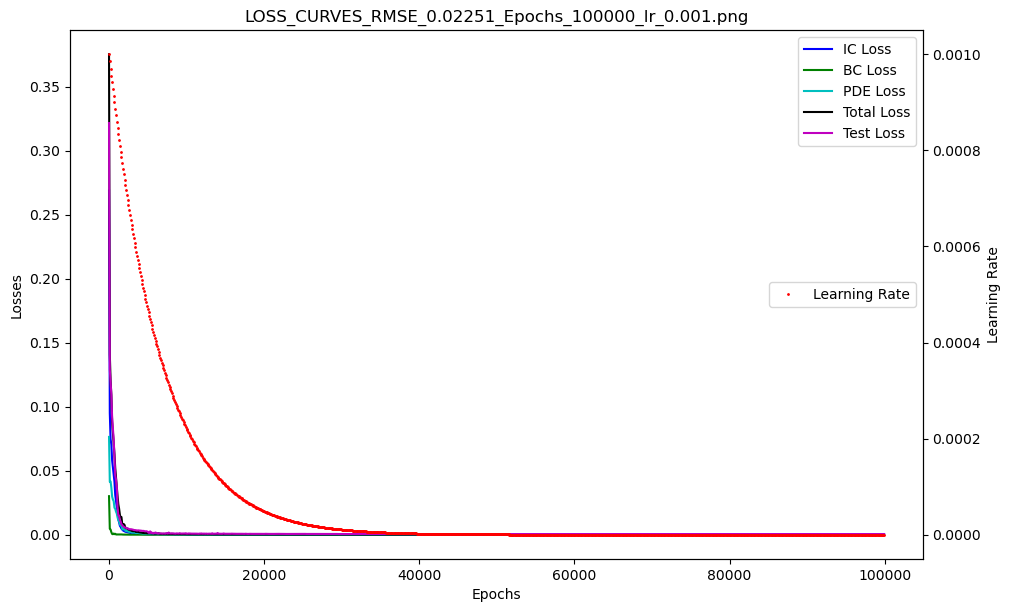

<Figure size 432x288 with 0 Axes>

In [315]:
file_name_loss = "LOSS_CURVES_RMSE_"+str(np.around(RMSE.item(),5))+"_Epochs_"+str(EPOCHS)+"_lr_"+str(initial_lr)+".png"
fig, ax1 = plt.subplots(figsize=(11, 7), dpi= 100)
ax2 = ax1.twinx()
ax1.plot(Epoch, IC_Loss, "b-",label = "IC Loss")
ax1.plot(Epoch, BC_Loss, "g-",label = "BC Loss")
ax1.plot(Epoch, PDE_Loss, "c-",label = "PDE Loss")
ax1.plot(Epoch, Total_Loss, "k-",label = "Total Loss")
ax1.plot(Epoch, Test_Loss, "m-",label = "Test Loss")
ax2.plot(Epoch,Learning_Rate, "ro",markersize=1,label = "Learning Rate")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses', color='k')
ax2.set_ylabel('Learning Rate', color='k')
ax2.legend(loc=7)
ax1.legend(loc=1)
plt.title(file_name_loss)
plt.show()
plt.savefig('Loss')

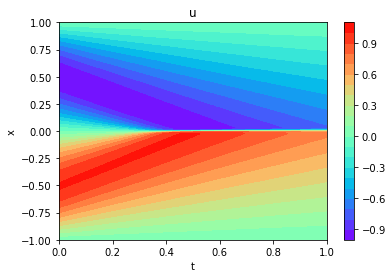

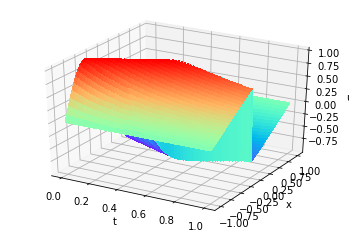

(torch.Size([256, 1]), torch.Size([100, 1]))

In [328]:
x = torch.linspace(-1, 1, total_points_x).view(-1,1)
t = torch.linspace(0, 1, total_points_t).view(-1,1)

plot3D(x,t,u_NN_2D)
x.shape, t.shape


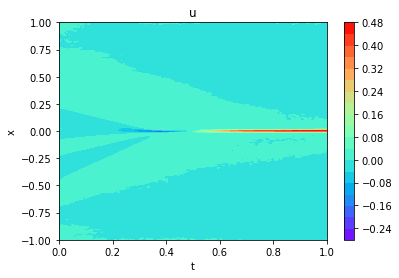

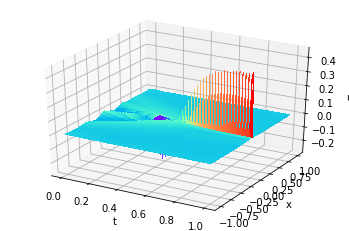

In [331]:


plot3D(x,t,(u_NN_2D - Exact.T)) #Error



In [307]:

u_NN_2D.shape,Exact.shape,x.shape, t.shape,X_u_train.shape


(torch.Size([256, 100]),
 torch.Size([100, 256]),
 torch.Size([256, 1]),
 torch.Size([100, 1]),
 (100, 2))

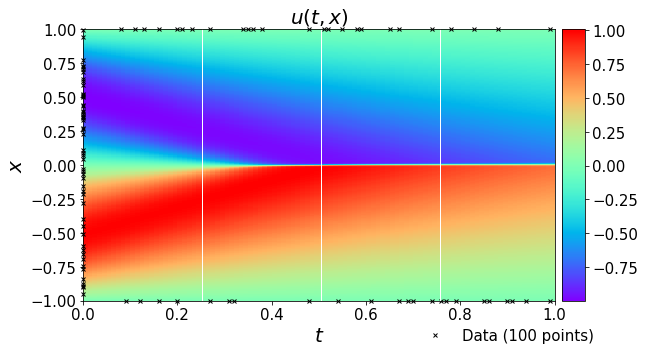

In [332]:
# 假设 U_pred, X_u_train, u_train, t, x, Exact 已经定义
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

# 使用 imshow 函数绘制 U_pred 的转置矩阵
h = ax.imshow(u_NN_2D, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

# 添加颜色条
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

# 绘制数据点
ax.plot(
    X_u_train[:, 1],
    X_u_train[:, 0],
    'kx', label='Data (%d points)' % (u_train.shape[0]),
    markersize=4,
    clip_on=False,
    alpha=1.0
)

# 绘制特定时间切片的垂直线
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25]*np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50]*np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[75]*np.ones((2, 1)), line, 'w-', linewidth=1)

# 设置坐标轴标签、图例和标题
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t, x)$', fontsize=20)
ax.tick_params(labelsize=15)

# 保存并显示图像
plt.savefig('burgers_solution.png')
plt.show()

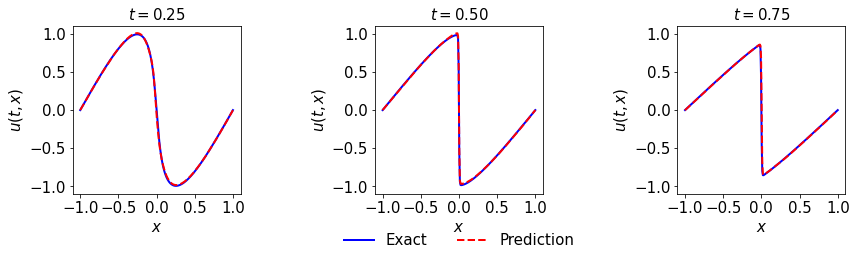

In [ ]:
fig = plt.figure(figsize=(14, 10))

# 创建网格布局
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

# 绘制 t = 0.25 时刻的精确解与预测结果
ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, u_NN_2D.T[25, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t, x)$')
ax.set_title('$t = 0.25$', fontsize=15)
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# 设置字体大小
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# 绘制 t = 0.50 时刻的精确解与预测结果
ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, u_NN_2D.T[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t, x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=15)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)

# 设置字体大小
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# 绘制 t = 0.75 时刻的精确解与预测结果
ax = plt.subplot(gs1[0, 2])
ax.plot(x, Exact[75, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, u_NN_2D.T[75, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t, x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.75$', fontsize=15)

# 设置字体大小
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# 保存并显示图像
plt.savefig('burgers_slices.png')
plt.show()